In [1]:
import pandas as pd
import numpy as np
import re
from functools import reduce
import seaborn as sns
from matplotlib import pyplot as plt
from lower_case_dict import d_dict as D_dict
from lower_case_dict import D_ocupaciones
from lower_case_dict import d_describe as D_describe
from traduce import leyenda as tr_leyenda
pd.options.display.max_columns=None
pd.options.display.max_colwidth=310
pd.options.mode.chained_assignment=None

In [2]:
# Dataset completo procesado
ruta='data/formacion_procesado.csv'
df=pd.read_csv(ruta,index_col=0,low_memory=False)

# Naive decision tree

**Clasificador de ocupaciones a partir de títulos al estilo de un arbol de decisión**, con la diferencia de que, en lugar de identificar el punto de corte más explicativo en cada etapa, este clasificador solo reparte en ramas una vez y crea **tantas ramas como títulos distintos** haya en el dataset.   

Para cada título identifica todas las ocupaciones, las ordena de más a menos frecuentes y  selecciona como predicción las ocupaciones en el **top n del ranking de frecuencias** que, además, estén por encima de un **umbral de frecuencia relativa establecido como mínimo**.   

Para cada título, este clasificador devuelve como **predicción una lista de ocupaciones ordenadas** de más a menos probables.   

Los **parámetros de este modelo** son el número n de posiciones en el ranking que se seleccionan como predictores y el umbral de frecuencia mínima.   

El número de ocupaciones en la predicción para cada título puede ser mayor o menor que  n, el número de posiciones en el ranking de frecuencias que se tienen en cuenta:   

- Si alguna ocupación en el top n del ranking tiene una frecuencia inferior al umbral, se descarta como predictor. Así, es posible que la lista de ocupaciones seleccionadas tenga menos de n elementos.  

- Cuando hay empates entre ocupaciones en el top n de frecuencias, se incluyen en la predicción todas las que pertenecen al grupo empatado. Esto hace posible que se seleccionen más de n ocupaciones como predicción. 

El funcionamiento del algoritmo se ha ilustrado empleando las columnas de título y de ocupacion literales en lugar de las nuḿericas. Se ha decidido así porque facilita el hacerse una idea de cuáles son las titulaciones para las que es más o menos probable hacer predicciones acertadas durante el proceso de construcción del clasificador. No obstante, el diseño del algoritmo permite sutituir las columnas literales por las numéricas para operar de forma más eficiente. También permite establecer otros regresores y targets. 


## Objetivo

El objetivo de la construcción de un clasificador elemental es conocer en qué medida las titulaciones universitarias explican por sí solas las profesiones que alcanzan los titulados.   
Se espera un éxito modesto por varios motivos:   

- Los títulos universitarios no son el único critero de los empleadores para seleccionar a su plantilla. Por un lado, un título universitario suele ser insuficiente por sí solo para aspirar a un buen número de puestos de trabajo reservados a universitarios. Por otro lado, a menudo los candidatos a un empleo pueden suplir la falta de un título universitario especializado a menudo con otros méritos, como la experiencia profesional o la formación en disciplinas afines. Los estudios de medicina son una excepción clara a esta posibilidad; los resultados constatan que las profesiones sanitarias están reservadas a titulados con formación especializada (aunque no todos los que tienen esa formación trabajan en ocupaciones relacionadas con su título). 

- Las encuestas empleadas en este proyecto solo informan con detalle de un título universitario de cada encuestado. Aquellos que han accedido a su profesión gracias a un título distinto del que les hace elegibles para la encuesta en la que participan (otro grado, otro máster, un título de doctor) se escapan a la capacidad predictiva de los modelos basados en estos datos.  Esto se notará especialmente en los casos en los que el encuestado responde sobre un título que ha estudiado por motivos distintos a búsqueda de empleo o la promoción profesional mientras trabajaban en ocupaciones a las que accedieron gracias a una titulación previa.  

- El mal funcionamiento del mercado de trabajo español empuja a muchos aspirantes a un empleo a aceptar trabajos poco o nada relacionados con su formación y sus conocimientos.   


## Justificación
**Ventajas de la construcción del algoritmo a medida** (en lugar de emplear una solución estándar):  
- **Simplicidad** de la justificación teórica que sustenta las predicciones. Facilita la interpretación de los resultados.  

- Clasificador **específico** para el caso en el que **el regresor y el target son variables categóricas**.  
  
- El proceso de construcción del algoritmo es, en su mayor parte, un **análisis descriptivo** de las relaciones entre titulaciones y ocupaciones. Este análisis se ha ilustrado y probado con los datos de la encuesta completa para estimar la dificultad del problema de clasificación (que se resuelve, más adelante, sobre subconjuntos de train, validación y test).  
  
- **Flexibilidad** para definir los criterios de agregación de las métricas de evaluación, por titulaciones o por ocupaciones. Facilita la identificación de los títulos y las profesiones para las que es más y menos probable hacer predicciones acertadas. 

# Dataset encuesta 

#### Observaciones con target informado

In [3]:
# Selección: solo ocupaciones informadas
df=df[df['ocupacion'].notna()]
df.shape

(59844, 311)

#### Número de categorías distintas del target: 

In [4]:
df['ocupacion'].nunique()
# Ocupaciones distintas (núm. categorías del target):

62

#### Número de categorías distintas del regresor: 

In [5]:
df['titulo_ppal_'].nunique()
# Titulos distintos (num. categorías del regresor principal): 

173

# Número de ocupaciones distintas por título

### Regresor y target:
En adelante se identifican el título principal como regresor y la ocupación como target. Esto facilitará la generalización del clasificador naive a otros targets y regresores. 

In [6]:
def num_cat_targets_por_cat_regresor(data,regresor,target):
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['nunique'])
    out.columns=out.columns.to_flat_index() 
    out.rename(columns={out.columns[-1]:'num categorias target para regresor'},inplace=True)
    out.sort_values(by='num categorias target para regresor',inplace=True)
    out.reset_index(inplace=True)
    
    return out

In [7]:
num_oc_por_titulo_encuesta=num_cat_targets_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_oc_por_titulo_encuesta.head(10)

,titulo_ppal_,num categorias target para regresor
0,Grado Odontología,5
1,Máster Odontología,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8
3,Máster Religión y teología,9
4,Máster Lenguas (Otros estudios),10
5,Grado Medicina,10
6,Máster Veterinaria,10
7,Grado Protocolo y eventos,11
8,Máster Estadística,11
9,Máster Enfermería,11


In [8]:
num_oc_por_titulo_encuesta.tail(10)

,titulo_ppal_,num categorias target para regresor
163,"Grado Ingeniería agrícola, agropecuaria y medio rural",50
164,Grado Actividad física y del deporte,50
165,Grado Trabajo social,51
166,Grado Educación infantil,52
167,Grado Ciencias ambientales,52
168,Grado Educación primaria,52
169,Grado Economía,53
170,Grado Historia,53
171,Grado Arquitectura técnica,53
172,Grado Administración y empresa,54


[Text(0.5, 1.0, 'Distribución del número de ocupaciones por título'),
 Text(0.5, 0, 'Número de ocupaciones por título')]

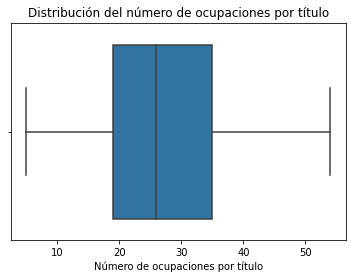

In [9]:
ax=sns.boxplot(data=num_oc_por_titulo_encuesta,x='num categorias target para regresor')
ax.set(title='Distribución del número de ocupaciones por título',xlabel='Número de ocupaciones por título')

Text(0, 0.5, 'Frecuencia')

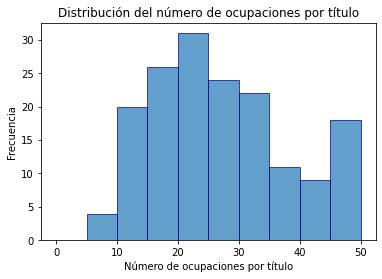

In [10]:
plt.hist(num_oc_por_titulo_encuesta['num categorias target para regresor'],bins=np.arange(0,55,5),\
         color='tab:blue',alpha=0.7,edgecolor='darkblue',linewidth=1)
plt.title('Distribución del número de ocupaciones por título')
plt.xlabel('Número de ocupaciones por título')
plt.ylabel('Frecuencia')

## Número de ocupaciones distintas por título: resumen 

In [11]:
num_oc_por_titulo_encuesta['num categorias target para regresor'].describe()

count    173.000000
mean      27.705202
std       12.290563
min        5.000000
25%       19.000000
50%       26.000000
75%       35.000000
max       54.000000
Name: num categorias target para regresor, dtype: float64

# Número de ocupaciones distintas por rama de conocimento

In [12]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título
df_ramas=df[['titulo_ppal_','rama_ppal_']].drop_duplicates()
df_ramas.head()

,titulo_ppal_,rama_ppal_
0,Grado Pedagogía,Ciencias sociales y jurídicas
398,Grado Pedagogía,Artes y humanidades
568,Grado Educación infantil,Ciencias sociales y jurídicas
1933,Grado Educación primaria,Ciencias sociales y jurídicas
3840,Grado Otros maestros,Ciencias sociales y jurídicas


In [13]:
num_oc_por_titulo_ramas=num_oc_por_titulo_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')
num_oc_por_titulo_ramas.head()

,titulo_ppal_,num categorias target para regresor,rama_ppal_
0,Grado Odontología,5,Ciencias de la salud
1,Máster Odontología,6,Ciencias de la salud
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8,Ciencias
3,Máster Religión y teología,9,Artes y humanidades
4,Máster Lenguas (Otros estudios),10,Artes y humanidades


[Text(0, 0, 'Ciencias de la salud'),
 Text(1, 0, 'Ciencias'),
 Text(2, 0, 'Artes y humanidades'),
 Text(3, 0, 'Ingeniería y arquitectura'),
 Text(4, 0, 'Ciencias sociales y jurídicas')]

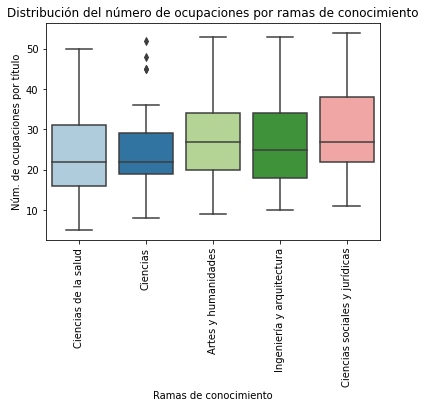

In [14]:
ax = sns.boxplot(data=num_oc_por_titulo_ramas, x='rama_ppal_',\
                                               y='num categorias target para regresor', palette='Paired')
ax.set(title='Distribución del número de ocupaciones por ramas de conocimiento',xlabel='Ramas de conocimiento',
       ylabel='Núm. de ocupaciones por título')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [15]:
df['ambito_g1_'].unique()

array(['Educación (Otros estudios) ',
       'Formación de docentes de enseñanza infantil ',
       'Formación de docentes de enseñanza primaria ',
       'Técnicas audiovisuales y medios de comunicación ',
       'Artes (Otros estudios) ', 'Humanidades ', 'Lenguas ', 'Economía ',
       'Ciencias sociales y del comportamiento (Otros estudios) ',
       'Psicología ', 'Periodismo y documentación ',
       'Negocios y administración (Otros estudios) ',
       'Dirección y administración ', 'Derecho ', 'Ciencias de la vida ',
       'Medio ambiente ', 'Ciencias químicas, físicas y geológicas ',
       'Matemáticas y estadística ', 'Informática',
       'Ingeniería y profesiones afines ',
       'Industria manufacturera y producción ',
       'Arquitectura y construcción ', 'Agricultura y ganadería ',
       'Silvicultura ', 'Veterinaria ', 'Salud (Otros estudios) ',
       'Medicina ', 'Enfermería ', 'Servicios sociales ',
       'Actividades físicas y deportivas ', 'Viajes, turismo y oc

In [16]:
df['ambito_m1_'].unique()

array([nan, 'SALUD Y SERVICIOS SOCIALES', 'EDUCACIÓN', 'INFORMÁTICA',
       'CIENCIAS', 'INGENIERÍA, INDUSTRIA Y CONSTRUCCIÓN',
       'NEGOCIOS, ADMINISTRACIÓN Y DERECHO', 'SERVICIOS',
       'CIENCIAS SOCIALES, PERIODISMO Y DOCUMENTACIÓN',
       'ARTES Y HUMANIDADES',
       'AGRICULTURA, GANADERÍA, SILVICULTURA, PESCA Y VETERINARIA'],
      dtype=object)

## Número de titulados por título: 

In [17]:
def num_obs_por_cat_regresor(data,regresor,target):
    
    columnas=[regresor,target]
    out=data[columnas].groupby([regresor]).agg(['count'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs regresor'},inplace=True)
    
    previo=num_cat_targets_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=out.merge(previo,on=regresor,how='outer')
    out=out.sort_values(by='num categorias target para regresor')
    out.reset_index(drop=True,inplace=True)
    
    return out

In [18]:
num_titulados_encuesta=num_obs_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_titulados_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor
0,Grado Odontología,243,5
1,Máster Odontología,73,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8
3,Máster Religión y teología,25,9
4,Máster Lenguas (Otros estudios),53,10


In [19]:
num_titulados_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor
168,Grado Educación primaria,2065,52
169,Grado Economía,1174,53
170,Grado Historia,697,53
171,Grado Arquitectura técnica,1050,53
172,Grado Administración y empresa,2637,54


## Número de profesionales por título y ocupación: 

In [20]:
def num_cat_target_por_regresor_y_target(data,regresor,target):
    
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['value_counts'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs target'},inplace=True)
    
    previo=num_obs_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=previo.merge(out,on=regresor,how='outer')
    out.sort_values(by=['num categorias target para regresor','obs target'],ascending=[True,False],inplace=True)
    
    return out

In [21]:
prof_por_oc_y_titulo_encuesta=num_cat_target_por_regresor_y_target(data=df,
                                                                   regresor='titulo_ppal_',target='ocupacion_')
prof_por_oc_y_titulo_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
0,Grado Odontología,243,5,Prof sanitarios,237
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2
2,Grado Odontología,243,5,Prof enseñanza,2
3,Grado Odontología,243,5,Directores producción y operaciones,1
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1


In [22]:
prof_por_oc_y_titulo_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1


## Proporción de profesionales sobre titulados por ocupación y título
Frecuencias relativas y frecuencias relativas acumuadas de las ocupaciones para cada título.   
(*) Para calcular las frecuencias acumuladas se ordenan las ocupaciones por frecuencia relativa en orden descendente. 

In [23]:
def frecuencias_cat_target_por_regresor(data,regresor,target):
    
    previo=num_cat_target_por_regresor_y_target(data=data,regresor=regresor,target=target)
    # 'prop' = proporción de obs. del target sobre núm. obs. para la categoría del regresor: 
    previo['prop']=previo['obs target'].div(previo['obs regresor'])
    
    # Frecuencias acumuladas: 
    acum=previo[[regresor,'prop']].groupby(regresor).cumsum()
    acum.rename(columns={acum.columns[-1]:'prop acum'},inplace=True)
    
    out=previo.merge(acum,left_index=True,right_index=True,how='outer')
    
    
    return out

In [24]:
proporciones_encuesta=frecuencias_cat_target_por_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
proporciones_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2,0.008230,0.983539
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000


In [25]:
proporciones_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000


## Ranking de ocupaciones por título: 

In [26]:
def ranking_cat_target_por_cat_regresor(data,regresor,target):
    
    previo=frecuencias_cat_target_por_regresor(data=data,regresor=regresor,target=target)
    rank=previo[[regresor,'obs target']]
    rank=rank.groupby(regresor).rank(method='min',ascending=False)
    rank.rename(columns={rank.columns[-1]:'rank'},inplace=True)
    
    out=previo.merge(rank,how='outer',left_index=True,right_index=True)
    out.sort_values(by=['num categorias target para regresor','rank'],inplace=True)
    
    return out 

In [27]:
ranking_encuesta=ranking_cat_target_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
ranking_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309,1.0
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2,0.008230,0.983539,2.0
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770,2.0
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885,4.0
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000,4.0


In [28]:
ranking_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483,48.0
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862,48.0
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242,48.0
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621,48.0
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000,48.0


In [29]:
# Inspección: 
ranking_encuesta[ranking_encuesta['titulo_ppal_']=='Grado Pedagogía']







# Falta más inspección títulos y núm categorías. 

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
3427,Grado Pedagogía,816,44,Prof enseñanza,380,0.465686,0.465686,1.0
3428,Grado Pedagogía,816,44,Prof eduación especial y no reglada,116,0.142157,0.607843,2.0
3429,Grado Pedagogía,816,44,Prof ciencias sociales,49,0.060049,0.667892,3.0
3430,Grado Pedagogía,816,44,Dependientes de comercio,33,0.040441,0.708333,4.0
3431,Grado Pedagogía,816,44,"Prof apoyo servicios jurídicos, socio-culturales, deportivos",24,0.029412,0.737745,5.0
3432,Grado Pedagogía,816,44,Trabajadores servicios de cuidados no de salud,22,0.026961,0.764706,6.0
3433,Grado Pedagogía,816,44,"Expertos en gestión, finanzas, comercio, etc",20,0.024510,0.789216,7.0
3434,Grado Pedagogía,816,44,Otros empleados administrativos con atención al público,18,0.022059,0.811275,8.0
3435,Grado Pedagogía,816,44,Prof sanitarios,17,0.020833,0.832108,9.0
3436,Grado Pedagogía,816,44,Empleados administrativos sin atención al público,12,0.014706,0.846814,10.0


# Ranking de ocupaciones más frecuentes por título (clasificador naive) 

Equivalente al proceso de entrenamiento.

In [30]:
def naive_fit(data,regresor,target,max_rank,min_prop):
    
    previo=ranking_cat_target_por_cat_regresor(data=data,regresor=regresor,target=target)
    
    naive=previo[previo['rank']<=max_rank]
    naive=naive[naive['prop']>=min_prop]
    
    naive.sort_values(by=['num categorias target para regresor',regresor,'rank'],inplace=True)
    naive.reset_index(drop=True,inplace=True)
    naive.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return naive

In [31]:
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_encuesta.sample(2)

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
376,Máster Control y tecnología medioambiental,113,27,Prof enseñanza,13,0.115044,0.460177,2.0
329,Grado Ingeniería en diseño industrial y desarrollo del producto,157,26,Prof enseñanza,12,0.076433,0.573248,3.0


In [32]:
#with pd.option_context("display.max_rows", naive_encuesta.shape[0]):
#    display(naive_encuesta)

# Entrenamiento, validación y test
Se separan los dataset de train, validación y test sin distinguir regresores y target porque es más conveniente mantener todas las columnas en un dataframe único para aplicar el algoritmo y evaluar los resultados. 

In [33]:
def train_vld_test(df):
    df.sample(frac=1,random_state=23) # reordenación aleatoria
    n_train=int(df.shape[0]*0.6)
    n_vld=int(df.shape[0]*0.8)
    df_train=df[:n_train]
    df_vld=df[n_train:n_vld]
    df_test=df[n_vld:]
    
    return df_train, df_vld, df_test

#### Dataset original: 

In [34]:
df_train, df_vld, df_test =train_vld_test(df)
df_train.shape[0]+df_vld.shape[0]+df_test.shape[0]==df.shape[0] # Comprobación

True

# Predicciones 

In [35]:
def naive_prediccion_instrumental(clasificador,valor_regresor):
    """ Predicciones y probabilidades para el valor del regresor según el clasificador entrenado.
    Conserva el número de categorías del target para cada categoría del regresor para usarlo en evaluación.
    """
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0]
    
    modelo=clasificador[clasificador[regresor]==valor_regresor]
    prediccion=modelo[[target,'prop','num categorias target para regresor']]
    prediccion.reset_index(drop=True,inplace=True)
    prediccion.rename(columns={target:'prediccion','prop':'probabilidad'},inplace=True)
    
    return prediccion

In [36]:
def naive_prediccion(clasificador,valor_regresor):
    """ Predicción en el formato en el que se muestra al interesado
    """
    prediccion=naive_prediccion_instrumental(clasificador,valor_regresor)
    prediccion=prediccion[['prediccion','probabilidad']]

    return prediccion

In [37]:
# Fit en train:
naive_5_05_train=naive_fit(data=df_train,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_5_05_train.head()  

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,125,4,Prof sanitarios,120,0.960000,0.960000,1.0
1,Máster Odontología,60,5,Prof sanitarios,54,0.900000,0.900000,1.0
2,Máster Odontología,60,5,Prof enseñanza,3,0.050000,0.950000,2.0
3,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",29,8,Prof enseñanza,12,0.413793,0.413793,1.0
4,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",29,8,"Prof ciencias, matemáticas e ingeniería",4,0.137931,0.551724,2.0


In [38]:
naive_5_05_train.tail()

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
693,Grado Administración y empresa,1757,52,"Expertos en gestión, finanzas, comercio, etc",344,0.195788,0.195788,1.0
694,Grado Administración y empresa,1757,52,"Empleados servicios financieros, contables y de apoyo",246,0.140011,0.335800,2.0
695,Grado Administración y empresa,1757,52,Empleados administrativos sin atención al público,218,0.124075,0.459875,3.0
696,Grado Administración y empresa,1757,52,Representantes e intermediarios,113,0.064314,0.524189,4.0
697,Grado Administración y empresa,1757,52,Prof derecho,97,0.055208,0.579397,5.0


In [39]:
# Inspección: 
naive_prediccion_instrumental(clasificador=naive_5_05_train,valor_regresor='Máster Odontología')

,prediccion,probabilidad,num categorias target para regresor
0,Prof sanitarios,0.90,5
1,Prof enseñanza,0.05,5


In [40]:
# Inspección: 
naive_prediccion(naive_5_05_train,valor_regresor='Grado Economía')

,prediccion,probabilidad
0,"Expertos en gestión, finanzas, comercio, etc",0.182504
1,"Empleados servicios financieros, contables y de apoyo",0.138763
2,Empleados administrativos sin atención al público,0.096531
3,Otros empleados administrativos con atención al público,0.067873
4,Representantes e intermediarios,0.063348


In [41]:
# Inspección: 
naive_prediccion(naive_5_05_train,valor_regresor='Grado Matemáticas')

,prediccion,probabilidad
0,Prof enseñanza,0.394040
1,Profesionales IT,0.145695
2,"Prof ciencias, matemáticas e ingeniería",0.119205
3,Técnicos TI,0.096026
4,"Expertos en gestión, finanzas, comercio, etc",0.072848


In [42]:
# Inspección: Ilustra empate múltiple
naive_prediccion(naive_5_05_train,valor_regresor='Máster Servicios de transporte')

,prediccion,probabilidad
0,"Prof ciencias, matemáticas e ingeniería",0.233333
1,Técnicos ciencias e ingenierías,0.100000
2,"Expertos en gestión, finanzas, comercio, etc",0.066667
3,"Supervisores ingeniería, industria y construcción",0.066667
4,"Empleados servicios financieros, contables y de apoyo",0.050000
5,Ocupaciones militares,0.050000
6,Prof apoyo gestión administrativa,0.050000
7,Representantes e intermediarios,0.050000


# Evaluación del clasificador

In [43]:
def naive_evalua(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    # evalua: dataset con regresores y targets en el set de evaluación
    evalua=data[[regresor,target]]
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                .apply(lambda valor: naive_prediccion_instrumental(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                .apply(lambda valor: naive_prediccion_instrumental(clasificador,valor)['probabilidad'].tolist())
    
    # Núm predicciones:
    evalua['num pred por regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    
    # Núm. categorías del target por regresor en el set de train:
    evalua['cat target por regresor (train)']=evalua[regresor]\
            .apply(lambda valor:\
            naive_prediccion_instrumental(clasificador,valor)['num categorias target para regresor'].unique()[0])

    # Columna 'acierto' (binaria)
    evalua['acierto']=evalua.apply(lambda row: row[target] in row['prediccion'],axis=1).astype(int)
    
    # Posición de predicción acertada: 
    evalua['posicion acierto']=evalua[evalua['acierto']==1]\
                              .apply(lambda row: row['prediccion'].index(row[target])+1,axis=1)
    
    # Columna 'probabilidad asociada la predicción acertada' (numerador de acierto ajustado por probabilidad):
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]\
                            .apply(lambda row: row['prediccion probs'][int(row['posicion acierto'])-1],axis=1)
    
    # Columna 'suma de probabilidades de predicciones' (denominador de acierto ajustado por probabilidad):
    evalua['suma prob prediccion']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob prediccion'])
    
    
    del evalua['prediccion probs']
    
    # Num. de observaciones para cada categoría del regresor:
    total_obs_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['count'])
    total_obs_por_cat_regresor.columns=total_obs_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs regresor'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del regresor: 
    aciertos_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['sum'])
    aciertos_por_cat_regresor.columns=aciertos_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos por cat regresor'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del regresor: 
    acierto_ajustado_por_cat_regresor=evalua[[regresor,'acierto ajustado']].groupby(regresor).agg(['sum'])
    acierto_ajustado_por_cat_regresor.columns=acierto_ajustado_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat regresor'},inplace=True)
    
    # Accuracy y accuracy ajustado para cada categoría del regresor: 
    evalua['accuracy regresor']=evalua['aciertos por cat regresor'].div(evalua['num obs regresor'])
    evalua['accuracy ajustado regresor']=evalua['aciertos ajustados por cat regresor']\
                                        .div(evalua['num obs regresor'])
    
    total_obs=evalua.shape[0]
    
    # Accuracy y accuracy ajustado poderados de cada categoría del regresor: 
    evalua['peso regresor']=evalua['num obs regresor']/total_obs
    evalua['accuracy ponderado regresor']=evalua['accuracy regresor']*evalua['peso regresor']
    evalua['accuracy ajustado ponderado regresor']=evalua['accuracy ajustado regresor']*evalua['peso regresor']
    
    # Num. de observaciones para cada categoría del target:
    total_obs_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['count'])
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs target'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del target: 
    aciertos_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['sum'])
    aciertos_por_cat_target.columns=aciertos_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos por cat target'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del target: 
    acierto_ajustado_por_cat_target=evalua[[target,'acierto ajustado']].groupby(target).agg(['sum'])
    acierto_ajustado_por_cat_target.columns=acierto_ajustado_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat target'},inplace=True)
  
    # Recall y recall ajustado para cada categoría del target:
    evalua['recall target']=evalua['aciertos por cat target'].div(evalua['num obs target'])
    evalua['recall ajustado target']=evalua['aciertos ajustados por cat target'].div(evalua['num obs target'])
    
    # Recall y recall ajustado ponderados para cada categoría del target: 
    evalua['peso target']=evalua['num obs target']/total_obs
    evalua['recall ponderado target']=evalua['recall target']*evalua['peso target']
    evalua['recall ajustado ponderado target']=evalua['recall ajustado target']*evalua['peso target']
    
    # Formato:
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return evalua

### Evaluación desagregada (en train):

In [44]:
naive_5_05_evalua_train=naive_evalua(clasificador=naive_5_05_train, data=df_train)
naive_5_05_evalua_train.sample(2)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
15367,Máster Actividades físicas y deportivas,"Prof apoyo servicios jurídicos, socio-culturales, deportivos","[Prof enseñanza, Prof apoyo servicios jurídicos, socio-culturales, deportivos, Prof sanitarios]",3,27,1,2.0,0.228814,0.661017,0.346154,118,78,33.000000,0.661017,0.279661,0.003286,0.002172,0.000919,880,355,109.405154,0.403409,0.124324,0.024508,0.009887,0.003047
25854,Grado Administración y empresa,"Prof ciencias, matemáticas e ingeniería","[Expertos en gestión, finanzas, comercio, etc, Empleados servicios financieros, contables y de apoyo, Empleados administrativos sin atención al público, Representantes e intermediarios, Prof derecho]",5,52,0,NaN,NaN,0.579397,NaN,1757,1018,244.159136,0.579397,0.138964,0.048933,0.028352,0.006800,3951,3591,1879.359045,0.908884,0.475667,0.110037,0.100011,0.052341


In [45]:
naive_5_05_evalua_train.head(5)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
0,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.013034,0.007715,0.004747,6523,6154,4056.066715,0.943431,0.62181,0.181669,0.171392,0.112963
1,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.013034,0.007715,0.004747,6523,6154,4056.066715,0.943431,0.62181,0.181669,0.171392,0.112963
2,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.013034,0.007715,0.004747,6523,6154,4056.066715,0.943431,0.62181,0.181669,0.171392,0.112963
3,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.013034,0.007715,0.004747,6523,6154,4056.066715,0.943431,0.62181,0.181669,0.171392,0.112963
4,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.013034,0.007715,0.004747,6523,6154,4056.066715,0.943431,0.62181,0.181669,0.171392,0.112963


In [46]:
accuracy_global_train=naive_5_05_evalua_train['acierto'].sum()/naive_5_05_evalua_train['acierto'].count()
accuracy_global_train

0.6688018715535008

### Evaluación desagregada (en validación):

In [47]:
naive_5_05_evalua_vld=naive_evalua(clasificador=naive_5_05_train, data=df_vld)

In [48]:
naive_5_05_evalua_vld.head(2)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
0,Máster Bioquímica,"Prof ciencias, matemáticas e ingeniería","[Prof ciencias, matemáticas e ingeniería, Técnicos ciencias e ingenierías, Prof sanitarios, Prof enseñanza]",4,19,1,1.0,0.294118,0.774510,0.379747,5,2,0.569620,0.400000,0.113924,0.000418,0.000167,0.000048,2152,2049,1041.879541,0.952138,0.484145,0.179798,0.171192,0.087048
1,Máster Electrónica y automática,"Prof ciencias, matemáticas e ingeniería","[Prof ciencias, matemáticas e ingeniería, Profesionales IT, Prof enseñanza, Técnicos TI]",4,18,1,1.0,0.361111,0.768519,0.469880,17,12,3.156627,0.705882,0.185684,0.001420,0.001003,0.000264,2152,2049,1041.879541,0.952138,0.484145,0.179798,0.171192,0.087048


In [49]:
accuracy_global_vld=naive_5_05_evalua_vld['acierto'].sum()/naive_5_05_evalua_vld['acierto'].count()
accuracy_global_vld

0.6903667808505305

# Métricas de evaluación: accuracy

In [50]:
def naive_evalua_accuracy(clasificador,data):
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_regresor=list(filter(lambda col: re.search('.*regresor.*',col),evalua.columns))
    
    evalua=evalua[lista_re_regresor].drop_duplicates()
    evalua.set_index(evalua.columns[0],inplace=True)
    evalua.sort_values(by='accuracy regresor',ascending=False,inplace=True)

    return evalua

In [51]:
naive_5_05_evalua_accuracy_vld=naive_evalua_accuracy(clasificador=naive_5_05_train,data=df_vld)

In [52]:
naive_5_05_evalua_accuracy_vld.shape, df_vld['titulo_ppal_'].nunique() # Comprobación: 

((128, 10), 128)

In [53]:
naive_5_05_evalua_accuracy_vld.head()

,num pred por regresor,cat target por regresor (train),num obs regresor,aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor
regresor: titulo_ppal_,,,,,,,,,,
Máster Matemáticas,5,12,6,6,2.372881,1.0,0.395480,0.000501,0.000501,0.000198
Máster Formación de docentes de enseñanza primaria,2,16,4,4,3.655172,1.0,0.913793,0.000334,0.000334,0.000305
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",5,8,2,2,0.269231,1.0,0.134615,0.000167,0.000167,0.000022
Máster Educación (Otros estudios),4,12,4,4,2.419355,1.0,0.604839,0.000334,0.000334,0.000202
Máster Ingeniería y procesos químicos,4,11,5,5,2.903226,1.0,0.580645,0.000418,0.000418,0.000243


In [54]:
naive_5_05_evalua_accuracy_vld.tail()

,num pred por regresor,cat target por regresor (train),num obs regresor,aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor
regresor: titulo_ppal_,,,,,,,,,,
Grado Historia,4,47,273,83,35.571429,0.304029,0.130298,0.022809,0.006935,0.002972
Máster Ciencias sociales y del comportamiento (Otros estudios),4,22,5,1,0.717391,0.200000,0.143478,0.000418,0.000084,0.000060
Máster Hostelería,4,11,2,0,0.000000,0.000000,0.000000,0.000167,0.000000,0.000000
Máster Silvicultura,6,15,2,0,0.000000,0.000000,0.000000,0.000167,0.000000,0.000000
Máster Religión y teología,2,8,1,0,0.000000,0.000000,0.000000,0.000084,0.000000,0.000000


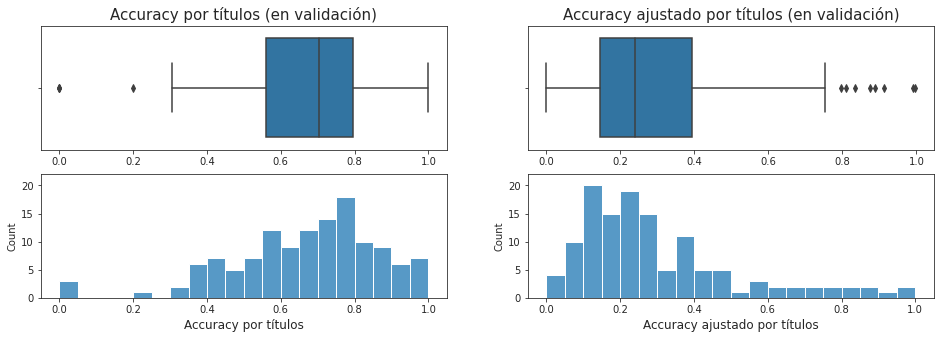

In [55]:
sns.set_style('ticks')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,x='accuracy regresor')
ax1.set_title('Accuracy por títulos (en validación)',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,x='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado por títulos (en validación)',fontsize=font_titles)
ax2.set_xlabel('',fontsize=font_labels)

sns.histplot(ax=ax3,data=naive_5_05_evalua_accuracy_vld,x='accuracy regresor',bins=np.arange(0,1.05,0.05))
ax3.set_xlabel('Accuracy por títulos',fontsize=font_labels)
ax3.set_ylim(0,22)

sns.histplot(ax=ax4,data=naive_5_05_evalua_accuracy_vld,x='accuracy ajustado regresor',bins=np.arange(0,1.05,0.05))
ax4.set_xlabel('Accuracy ajustado por títulos',fontsize=font_labels)
ax4.set_ylim(0,22)

fig.subplots_adjust(hspace=.2)
plt.show()

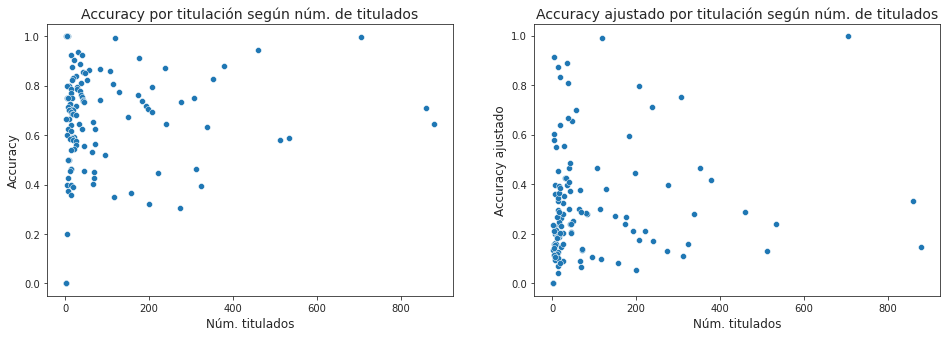

In [56]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.scatterplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy regresor')
ax1.set_title('Accuracy por titulación según núm. de titulados',fontsize=font_titles) 
ax1.set_xlabel('Núm. titulados',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado por titulación según núm. de titulados',fontsize=font_titles) 
ax2.set_xlabel('Núm. titulados',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [57]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy regresor']].corr()

,num obs regresor,accuracy regresor
num obs regresor,1.000000,0.071733
accuracy regresor,0.071733,1.000000


In [58]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy ajustado regresor']].corr()

,num obs regresor,accuracy ajustado regresor
num obs regresor,1.000000,0.117879
accuracy ajustado regresor,0.117879,1.000000


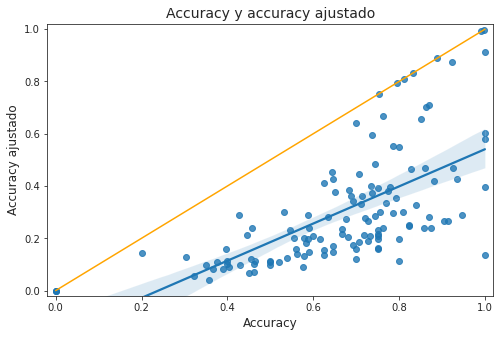

In [59]:
sns.set_style('ticks')

fig, ax = plt.subplots(1, 1,figsize=(8,5))
font_titles=14
font_labels=12

sns.regplot(data=naive_5_05_evalua_accuracy_vld,
            x='accuracy regresor', 
            y='accuracy ajustado regresor')

sns.lineplot(data=naive_5_05_evalua_accuracy_vld,
                x='accuracy regresor',
                y='accuracy regresor',color='orange')

ax.set_title('Accuracy y accuracy ajustado',fontsize=font_titles) 
ax.set_xlabel('Accuracy',fontsize=font_labels)
ax.set_xlim(-0.02,1.02)
ax.set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax.set_ylim(-0.02,1.02)

plt.show()

In [60]:
naive_5_05_evalua_accuracy_vld[['accuracy regresor','accuracy ajustado regresor']].corr()

,accuracy regresor,accuracy ajustado regresor
accuracy regresor,1.000000,0.651952
accuracy ajustado regresor,0.651952,1.000000


In [61]:
explora_accuracy=naive_5_05_evalua_accuracy_vld

explora_accuracy['dif acc']=explora_accuracy['accuracy regresor']-explora_accuracy['accuracy ajustado regresor']
explora_accuracy[explora_accuracy['dif acc']<.1].sort_values(by=['accuracy regresor','dif acc'],ascending=False)
# Los puntos próximos a la recta identidad: 

,num pred por regresor,cat target por regresor (train),num obs regresor,aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,dif acc
regresor: titulo_ppal_,,,,,,,,,,,
Máster Formación de docentes de enseñanza primaria,2,16,4,4,3.655172,1.000000,0.913793,0.000334,0.000334,0.000305,0.086207
Grado Medicina,1,9,704,702,702.000000,0.997159,0.997159,0.058819,0.058652,0.058652,0.000000
Grado Odontología,1,4,118,117,117.000000,0.991525,0.991525,0.009859,0.009775,0.009775,0.000000
Máster Odontología,2,5,13,12,11.368421,0.923077,0.874494,0.001086,0.001003,0.000950,0.048583
Grado Fisioterapia,1,17,36,32,32.000000,0.888889,0.888889,0.003008,0.002674,0.002674,0.000000
Máster Enfermería,1,10,18,15,15.000000,0.833333,0.833333,0.001504,0.001253,0.001253,0.000000
Grado Enfermería,1,25,37,30,30.000000,0.810811,0.810811,0.003091,0.002506,0.002506,0.000000
Grado Farmacia,1,19,206,164,164.000000,0.796117,0.796117,0.017211,0.013702,0.013702,0.000000
Grado Trabajo social,2,45,38,29,25.314136,0.763158,0.666161,0.003175,0.002423,0.002115,0.096996


In [62]:
# Ilustra conveniencia de accuracy ajustado: 
explora_accuracy[explora_accuracy.index=='Máster Servicios de transporte']

,num pred por regresor,cat target por regresor (train),num obs regresor,aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,dif acc
regresor: titulo_ppal_,,,,,,,,,,,
Máster Servicios de transporte,8,21,5,4,0.575,0.8,0.115,0.000418,0.000334,0.000048,0.685


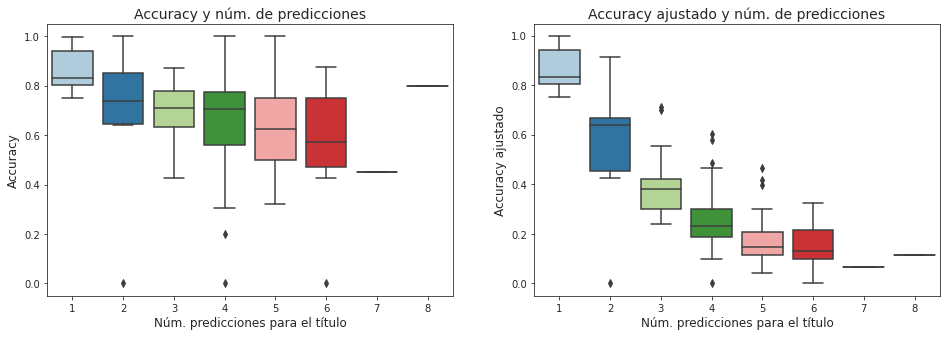

In [63]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y='accuracy regresor',
                palette='Paired')
ax1.set_title('Accuracy y núm. de predicciones',fontsize=font_titles) 
ax1.set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y='accuracy ajustado regresor',
                palette='Paired')
ax2.set_title('Accuracy ajustado y núm. de predicciones',fontsize=font_titles) 
ax2.set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [64]:
# El accuracy decrece con el núm de predicciones porque más predicciones implica menos concentración en las 
# ocupaciones de los titulados. En el no ajustado se nota menos porque se compensa con más predicciones. En el 
# ajustado se aprecia el efecto (las predicciones débiles puntuan menos)

In [65]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy regresor']].corr()

,num pred por regresor,accuracy regresor
num pred por regresor,1.000000,-0.240186
accuracy regresor,-0.240186,1.000000


In [66]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy ajustado regresor']].corr()

,num pred por regresor,accuracy ajustado regresor
num pred por regresor,1.000000,-0.751198
accuracy ajustado regresor,-0.751198,1.000000


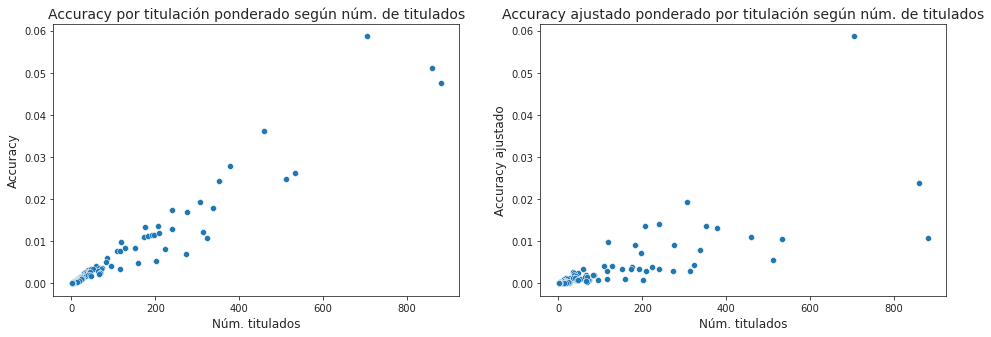

In [67]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.scatterplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ponderado regresor')
ax1.set_title('Accuracy por titulación ponderado según núm. de titulados',fontsize=font_titles) 
ax1.set_xlabel('Núm. titulados',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ajustado ponderado regresor')
ax2.set_title('Accuracy ajustado ponderado por titulación según núm. de titulados',fontsize=font_titles) 
ax2.set_xlabel('Núm. titulados',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [68]:
# Accuracy ajustado minora el efecto de ponderación por núm. de titulados: las titulaciones con más peso 
# (más titulados) pesan más en el agregado porque tienen ponderación más fuerte . Esto oculta que pueden 
# tener predicciones menos firmes (más ocupaciones posibles, menos prob). El accuracy ajustado corrige este
# efecto. 
# Naturalmente, el accuracy ponderado es creciente con el núm. de titulados. 
#######################################################Cuidado con el eje y arriba

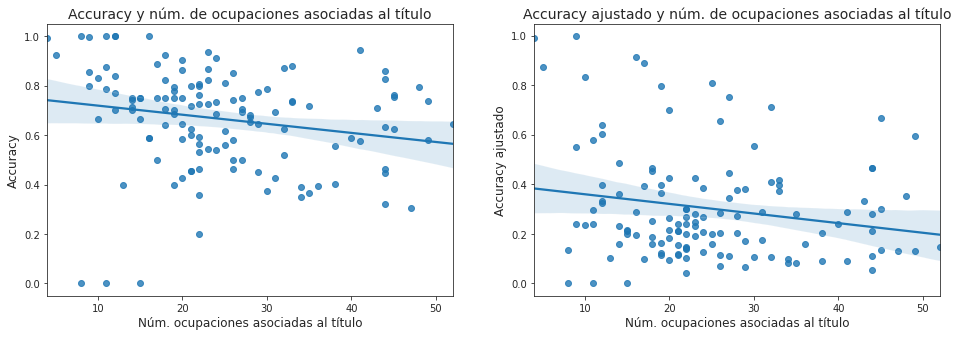

In [69]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.regplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='cat target por regresor (train)',
                y='accuracy regresor')
ax1.set_title('Accuracy y núm. de ocupaciones asociadas al título',fontsize=font_titles) 
ax1.set_xlabel('Núm. ocupaciones asociadas al título',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.regplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='cat target por regresor (train)',
                y='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado y núm. de ocupaciones asociadas al título',fontsize=font_titles) 
ax2.set_xlabel('Núm. ocupaciones asociadas al título',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [70]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy regresor']].corr()

,cat target por regresor (train),accuracy regresor
cat target por regresor (train),1.000000,-0.198861
accuracy regresor,-0.198861,1.000000


In [71]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy ajustado regresor']].corr()

,cat target por regresor (train),accuracy ajustado regresor
cat target por regresor (train),1.000000,-0.192572
accuracy ajustado regresor,-0.192572,1.000000


# Métricas de evaluación: recall

In [72]:
def naive_evalua_recall(clasificador,data):
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_target=list(filter(lambda col: re.search('.*target.*',col),evalua.columns))
    lista_re_target=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_target))
    
    evalua=evalua[lista_re_target].drop_duplicates()
    evalua.set_index(evalua.columns[0],inplace=True)
    evalua.sort_values(by='recall target',ascending=False,inplace=True)

    return evalua

In [73]:
naive_5_05_evalua_recall_vld=naive_evalua_recall(clasificador=naive_5_05_train,data=df_vld)

In [74]:
naive_5_05_evalua_recall_vld.shape, df_vld['ocupacion_'].nunique() # Comprobación

((60, 8), 60)

In [75]:
naive_5_05_evalua_recall_vld.head()

,num obs target,aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
Prof sanitarios,1623,1570,1381.723071,0.967344,0.851339,0.135600,0.131172,0.115442
"Prof ciencias, matemáticas e ingeniería",2152,2049,1041.879541,0.952138,0.484145,0.179798,0.171192,0.087048
Prof derecho,544,516,291.261348,0.948529,0.535407,0.045451,0.043111,0.024335
Prof enseñanza,1207,1067,579.548882,0.884010,0.480156,0.100844,0.089147,0.048421
Técnicos ciencias e ingenierías,275,223,59.829412,0.810909,0.217561,0.022976,0.018631,0.004999


In [76]:
naive_5_05_evalua_recall_vld.tail()

,num obs target,aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
"Mecánicos de precisión, artesanos y artes gráficas",13,0,0.0,0.0,0.0,0.001086,0.0,0.0
Política y dirección Admón Pública,45,0,0.0,0.0,0.0,0.003760,0.0,0.0
Prof apoyo finanzas y matemáticas,13,0,0.0,0.0,0.0,0.001086,0.0,0.0
Vendedores excepto comercio,30,0,0.0,0.0,0.0,0.002506,0.0,0.0
"Soldadores, chapistas, montadores de estructuras",2,0,0.0,0.0,0.0,0.000167,0.0,0.0


In [77]:
#with pd.option_context("display.max_rows", naive_5_05_evalua_recall_vld.shape[0]):
#    display(naive_5_05_evalua_recall_vld)

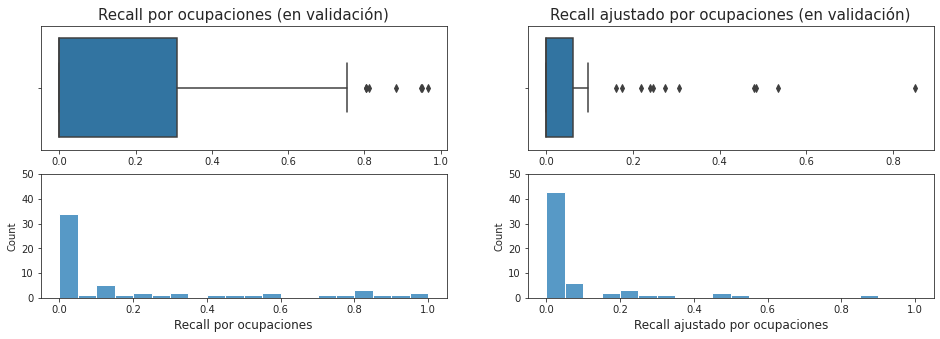

In [78]:
sns.set_style('ticks')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_recall_vld,x='recall target')
ax1.set_title('Recall por ocupaciones (en validación)',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='recall ajustado target')
ax2.set_title('Recall ajustado por ocupaciones (en validación)',fontsize=font_titles)
ax2.set_xlabel('',fontsize=font_labels)

sns.histplot(ax=ax3,data=naive_5_05_evalua_recall_vld,x='recall target',bins=np.arange(0,1.05,0.05))
ax3.set_xlabel('Recall por ocupaciones',fontsize=font_labels)
ax3.set_ylim(0,50)

sns.histplot(ax=ax4,data=naive_5_05_evalua_recall_vld,x='recall ajustado target',bins=np.arange(0,1.05,0.05))
ax4.set_xlabel('Recall ajustado por ocupaciones',fontsize=font_labels)
ax4.set_ylim(0,50)

fig.subplots_adjust(hspace=.2)
plt.show()

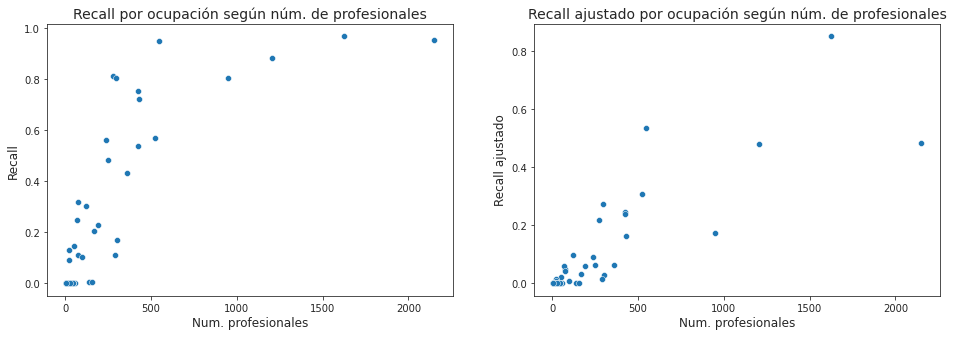

In [79]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12


sns.scatterplot(ax=ax1,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall target')
ax1.set_title('Recall por ocupación según núm. de profesionales',fontsize=font_titles)
ax1.set_xlabel('Num. profesionales',fontsize=font_labels)
ax1.set_ylabel('Recall',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall ajustado target')
ax2.set_title('Recall ajustado por ocupación según núm. de profesionales',fontsize=font_titles)
ax2.set_xlabel('Num. profesionales',fontsize=font_labels)
ax2.set_ylabel('Recall ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [80]:
display(naive_5_05_evalua_recall_vld[['num obs target','recall target']].corr(),
        naive_5_05_evalua_recall_vld[['num obs target','recall ajustado target']].corr())

,num obs target,recall target
num obs target,1.000000,0.796044
recall target,0.796044,1.000000


,num obs target,recall ajustado target
num obs target,1.000000,0.859582
recall ajustado target,0.859582,1.000000


## Conclusiones

###### 1. El rendimiento evaluado por títulos (accuracy) es muy superior al recall evaluado por ocupaciones    

- El dataset es una **encuesta sobre titulados universitarios**: el muestreo está diseñado para garantizar una presencia representativa de los títulos universitarios, no de las ocupaciones profesionales. Los puestos de trabajo que no requieren formación universitaria están infrarepresentados respecto a su peso en la población general.  


###### 2. El accuracy para cada título es poco dependiente del número de egresados de la titulación     

###### 3. El recall por ocupaciones tiene una relación fuerte y directa con el número de profesionales encuestados  

- El **peor rendimiento** se da, sobre todo, en **ocupaciones que no requieren titulación universitaria**: las ocupaciones con **recall nulo** son profesiones no cualificadas u ocupaciones cuya formación especializada es no universitaria, con las excepciones de los profesionales en política y dirección de la Administración Pública y los profesionales de apoyo en finanzas y matemáticas. 
- Las ocupaciones con recall nulo son, también, las más infrarepresentadas en la encuesta. 

# Metricas de evaluación: precisión

In [81]:
# Dataframe para pruebas de función naive_evalua_rhs: 
df_prueba=pd.DataFrame({'titulo_ppal_':['Grado Derecho','Grado Derecho','Grado Derecho',
                                        'Grado Administración y empresa','Grado Medicina'],
                        'ocupacion_':['Prof derecho','Prof derecho',
                                      'Empleados servicios financieros, contables y de apoyo','Prof derecho',
                                      'Prof sanitarios']},
                       index=[50,51,52,53,54])

In [135]:
def naive_evalua_rhs(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    evalua=data[[regresor,target]]
    
    total_obs=evalua.shape[0]
    
    # Num. de observaciones para cada categoría del target (numerador pesos de precisiones ponderadas):
    total_obs_por_cat_target=evalua.groupby(target).agg(['count']) # cuenta sobre target observado
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer') 
    evalua.rename(columns={evalua.columns[-1]:'num obs cat target'},inplace=True)
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                         .apply(lambda valor: naive_prediccion(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                         .apply(lambda valor: naive_prediccion(clasificador,valor)['probabilidad'].tolist())
    
    # Columna 'suma de prob. de pred. por regresor' (denominador de acierto ajustado por probabilidad):
    # Se hace aquí para eleminar listas del dataframe (interfieren en comparaciones de filas)
    evalua['suma prob pred por regresor']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Núm predicciones:
    evalua['num pred para regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    max_rank=evalua['num pred para regresor'].max()
    
    for i in range(max_rank):
        # Se sacan las predicciones de la lista y se convierten en columnas:  
        evalua['pred'+str(i)]=evalua['prediccion'][evalua['num pred para regresor']>=i+1]\
                             .apply(lambda lista:lista[i])
        # Se sacan las probabilidades de las predicciones de la lista y se convierten en columnas: 
        evalua['p'+str(i)]=evalua['prediccion probs'][evalua['num pred para regresor']>=i+1]\
                          .apply(lambda lista:lista[i])   

    del evalua['prediccion'], evalua['prediccion probs'] # listas interfieren en comparaciones de filas
    
    # Se odenan todas la predicciones para una observacion (previamente en cols) en filas:
    # Para cada obs., una fila por predicción: filas dénticas salvo por el valor de la predicción y su prob. 
    # Las obs. dejan de corresponderse con filas (varias pred. para una obs.)
    # Las predicciones ordenadas en 2 columnas: predicciones del target y prob. de las predicciones
    
    evalua.rename(columns={'pred0':'predicciones target','p0':'predicciones prob'},inplace=True)
    
    for i in range(1,max_rank):
        aux=evalua[evalua.columns.drop(['predicciones target','predicciones prob'])]
        aux.rename(columns={'pred'+str(i):'predicciones target','p'+str(i):'predicciones prob'},inplace=True)     
        # Prescinde de filas con nan por titulaciones con menos predicciones que otras: 
        aux=aux[aux['predicciones target'].notna()]
        del evalua['pred'+str(i)], evalua['p'+str(i)]
        # Merge conservando índices para identificar observaciones distintas (no se corresponden con filas):
        for df in [evalua,aux]:
            df.reset_index(inplace=True)
        evalua=evalua.merge(aux,how='outer')
        evalua.drop_duplicates(inplace=True)
        evalua.set_index('index',inplace=True)
    
    # Para desligar por índice y asignar valores distintos en col. nuevas para misma obs.: 
    evalua.reset_index(drop=False,inplace=True) 
    evalua.sort_values(by='index',inplace=True)
    
    # Aciertos (binaria):
    evalua['acierto']=0
    evalua['acierto'].mask(evalua['predicciones target']==evalua[target],1,inplace=True)
   
    # Probabilidades de las predicciones acertadas:
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]['predicciones prob']
    
    # Núm. de aciertos (binaria) para cada predicción: 
    aciertos_por_prediccion=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['sum'])
    aciertos_por_prediccion.columns=aciertos_por_prediccion.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_prediccion,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred acertadas'},inplace=True)
    
    # Núm. de repeticiones de cada predicción: 
    repeticiones_pred=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['count'])
    repeticiones_pred.columns=repeticiones_pred.columns.to_flat_index()
    evalua=evalua.merge(repeticiones_pred,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred'},inplace=True)

    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob pred por regresor'])

    # Suma aciertos ajustados para cada predicción: 
    suma_aciertos_ajustados=evalua[['predicciones target','acierto ajustado']]\
                                           .groupby('predicciones target').agg(['sum'])
    suma_aciertos_ajustados.columns=suma_aciertos_ajustados.columns.to_flat_index()
    evalua=evalua.merge(suma_aciertos_ajustados,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por pred'},inplace=True)
    
    # Precisión y precisión ajustada por predicción: 
    evalua['precision pred']=evalua['num pred acertadas'].div(evalua['num pred'])
    evalua['precision ajustada pred']=evalua['aciertos ajustados por pred']\
                                          .div(evalua['num pred'])
   
    # Pesos de predicciones = num. obs. de target predicho entre total obs.: 
    pesos_pred=evalua[[target,'num obs cat target']]
    pesos_pred['peso pred']=pesos_pred['num obs cat target']/total_obs
    pesos_pred=pesos_pred[[target,'peso pred']]
    pesos_pred.rename(columns={target:'predicciones target'},inplace=True)
    pesos_pred.drop_duplicates(inplace=True)
    evalua=evalua.merge(pesos_pred,on='predicciones target',how='left')
    evalua['peso pred'].fillna(0,inplace=True) # para predicciones no observadas
    
    # Precisión y precisión ajustada ponderada para cada predicción:    
    evalua['precision ponderada pred']=evalua['precision pred']*evalua['peso pred']
    evalua['precision ajustada ponderada pred']=evalua['precision ajustada pred']*evalua['peso pred']
    
    # Formato:
    evalua.set_index('index',inplace=True)
    evalua.sort_index(inplace=True)
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)

    return evalua

In [83]:
prueba=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_prueba)
prueba

,regresor: titulo_ppal_,target: ocupacion_,num obs cat target,suma prob pred por regresor,num pred para regresor,predicciones target,predicciones prob,acierto,prob pred acertada,num pred acertadas,num pred,acierto ajustado,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,presicion ajustada ponderada pred
index,,,,,,,,,,,,,,,,,,
0,Grado Derecho,Prof derecho,3,0.635549,4,Prof derecho,0.391337,1,0.391337,3,4,0.615746,1.326777,0.75,0.331694,0.6,0.45,0.199017
0,Grado Derecho,Prof derecho,3,0.635549,4,Empleados administrativos sin atención al público,0.073189,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
0,Grado Derecho,Prof derecho,3,0.635549,4,"Empleados servicios financieros, contables y de apoyo",0.050037,0,NaN,1,4,NaN,0.078731,0.25,0.019683,0.2,0.05,0.003937
0,Grado Derecho,Prof derecho,3,0.635549,4,"Expertos en gestión, finanzas, comercio, etc",0.120986,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
1,Grado Derecho,Prof derecho,3,0.635549,4,"Empleados servicios financieros, contables y de apoyo",0.050037,0,NaN,1,4,NaN,0.078731,0.25,0.019683,0.2,0.05,0.003937
1,Grado Derecho,Prof derecho,3,0.635549,4,"Expertos en gestión, finanzas, comercio, etc",0.120986,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
1,Grado Derecho,Prof derecho,3,0.635549,4,Prof derecho,0.391337,1,0.391337,3,4,0.615746,1.326777,0.75,0.331694,0.6,0.45,0.199017
1,Grado Derecho,Prof derecho,3,0.635549,4,Empleados administrativos sin atención al público,0.073189,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
2,Grado Administración y empresa,Prof derecho,3,0.579397,5,Prof derecho,0.055208,1,0.055208,3,4,0.095285,1.326777,0.75,0.331694,0.6,0.45,0.199017


### Evaluación desagregada (en validación) 

In [84]:
naive_5_05_evalua_rhs_vld=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_vld)

In [85]:
naive_5_05_evalua_rhs_vld.head()

,regresor: titulo_ppal_,target: ocupacion_,num obs cat target,suma prob pred por regresor,num pred para regresor,predicciones target,predicciones prob,acierto,prob pred acertada,num pred acertadas,num pred,acierto ajustado,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,presicion ajustada ponderada pred
index,,,,,,,,,,,,,,,,,,
0,Máster Bioquímica,"Prof ciencias, matemáticas e ingeniería",2152,0.774510,4,"Prof ciencias, matemáticas e ingeniería",0.294118,1,0.294118,2049,4583,0.379747,1041.879541,0.447087,0.227336,0.179798,0.080385,0.040874
0,Máster Bioquímica,"Prof ciencias, matemáticas e ingeniería",2152,0.774510,4,Técnicos ciencias e ingenierías,0.176471,0,NaN,223,2842,NaN,59.829412,0.078466,0.021052,0.022976,0.001803,0.000484
0,Máster Bioquímica,"Prof ciencias, matemáticas e ingeniería",2152,0.774510,4,Prof enseñanza,0.147059,0,NaN,1067,6886,NaN,579.548882,0.154952,0.084163,0.100844,0.015626,0.008487
0,Máster Bioquímica,"Prof ciencias, matemáticas e ingeniería",2152,0.774510,4,Prof sanitarios,0.156863,0,NaN,1570,2866,NaN,1381.723071,0.547802,0.482109,0.135600,0.074282,0.065374
1,Máster Industria de la alimentación,"Prof ciencias, matemáticas e ingeniería",2152,0.701031,5,Técnicos ciencias e ingenierías,0.298969,0,NaN,223,2842,NaN,59.829412,0.078466,0.021052,0.022976,0.001803,0.000484


In [86]:
naive_5_05_evalua_rhs_vld['predicciones target'].nunique()
# Núm. de predicciones distintas:

30

In [87]:
naive_5_05_evalua_rhs_vld['target: ocupacion_'].nunique()
# Núm. de ocupaciones distintas observadas: 

60

## Precisión agregada por predicciones

In [88]:
def naive_evalua_precision(clasificador=naive_5_05_train,data=df_prueba):
    
    """
    adaptar
    """
    
    evalua=naive_evalua_rhs(clasificador=clasificador,data=data)
    
    import re
    lista_re_pred=list(filter(lambda col: re.search('.*pred.*',col),evalua.columns))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_pred))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*prob.*)',col),lista_re_pred))
    lista_re_pred=[lista_re_pred[0]]+[lista_re_pred[2]]+[lista_re_pred[1]]+lista_re_pred[3:]
    
    evalua=evalua[lista_re_pred].drop_duplicates()
    
    evalua.set_index('predicciones target',inplace=True)
    evalua.sort_values(by='precision pred',ascending=False,inplace=True)

    return evalua

In [89]:
naive_5_05_precision_vld=naive_evalua_precision(clasificador=naive_5_05_train,data=df_vld)

In [90]:
naive_5_05_precision_vld.shape[0], df_vld['ocupacion_'].nunique() # Comprobación: 
# El núm de ocupaciones predichas es la cuarta parte del núm. de ocupaciones observadas en validación

(30, 60)

In [91]:
naive_5_05_precision_vld

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,presicion ajustada ponderada pred
predicciones target,,,,,,,,
Prof sanitarios,2866,1570,1381.723071,0.547802,0.482109,0.135600,0.074282,0.065374
"Prof ciencias, matemáticas e ingeniería",4583,2049,1041.879541,0.447087,0.227336,0.179798,0.080385,0.040874
"Empleados servicios financieros, contables y de apoyo",2446,762,164.471590,0.311529,0.067241,0.079121,0.024649,0.005320
Prof derecho,1930,516,291.261348,0.267358,0.150913,0.045451,0.012152,0.006859
Prof ciencias sociales,1319,298,160.967708,0.225929,0.122038,0.043780,0.009891,0.005343
Prof apoyo gestión administrativa,5,1,0.075000,0.200000,0.015000,0.011530,0.002306,0.000173
Técnicos TI,1729,312,69.733204,0.180451,0.040332,0.036010,0.006498,0.001452
Prof enseñanza,6886,1067,579.548882,0.154952,0.084163,0.100844,0.015626,0.008487
Profesionales IT,1637,228,101.154302,0.139279,0.061792,0.035341,0.004922,0.002184


# Resúmenes de métricas de evaluación 

In [92]:
def naive_evalua_criterio_resumen(clasificador,data,criterio):
    """ Función instrumental: generaliza el proceso de resumen de la evaluación de acuerdo con un 'criterio' 
    que se concretará como accuracy, como recall o como precision.
    """
    if criterio=='accuracy':
        evalua=naive_evalua_accuracy(clasificador=clasificador,data=data)
    if criterio=='recall':
        evalua=naive_evalua_recall(clasificador=clasificador,data=data)
    if criterio=='precision':
        evalua=naive_evalua_precision(clasificador=clasificador,data=data)
    
    evalua_resumen=evalua.agg(['sum','mean','median','min','argmin','max','argmax'])
    
    # Ajustes argmin y argmax: 
    for col in evalua.columns: 
        for arg in ['argmin','argmax']:
            indice=int(evalua_resumen.loc[arg,col])
            evalua_resumen.loc[arg,col]=evalua.index[indice]

    return evalua_resumen

In [93]:
def naive_evalua_accuracy_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='accuracy')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','accuracy regresor']=''
    evalua.loc['sum','accuracy ajustado regresor']=''
    
    return evalua

In [94]:
def naive_evalua_recall_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='recall')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','recall target']=''
    evalua.loc['sum','recall ajustado target']=''
    
    return evalua

In [95]:
def naive_evalua_precision_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='precision')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','precision pred']=''
    evalua.loc['sum','precision ajustada pred']=''
    
    return evalua

In [96]:
naive_5_05_evalua_accuracy_resumen_vld=naive_evalua_accuracy_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_accuracy_resumen_vld

,num pred por regresor,cat target por regresor (train),num obs regresor,aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor
sum,515,3145,11969,8263,4151.96,,,1,0.690367,0.346893
mean,4.02344,24.5703,93.5078,64.5547,32.4372,0.666067,0.303348,0.0078125,0.00539349,0.0027101
median,4,22,25,18.5,7.7131,0.702792,0.238711,0.00208873,0.00154566,0.000644423
min,1,4,1,0,0,0,0,8.35492e-05,0,0
argmin,Grado Medicina,Grado Odontología,Máster Religión y teología,Máster Hostelería,Máster Hostelería,Máster Hostelería,Máster Hostelería,Máster Religión y teología,Máster Hostelería,Máster Hostelería
max,8,52,880,702,702,1,0.997159,0.0735233,0.0586515,0.0586515
argmax,Máster Servicios de transporte,Grado Administración y empresa,Grado Administración y empresa,Grado Medicina,Grado Medicina,Máster Matemáticas,Grado Medicina,Grado Administración y empresa,Grado Medicina,Grado Medicina


In [97]:
naive_5_05_evalua_recall_resumen_vld=naive_evalua_recall_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_recall_resumen_vld

,num obs target,aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
sum,11969,8263,4151.96,,,1,0.690367,0.346893
mean,199.483,137.717,69.1994,0.206904,0.0771543,0.0166667,0.0115061,0.00578155
median,41,0,0,0,0,0.00342552,0,0
min,1,0,0,0,0,8.35492e-05,0,0
argmin,Montadores y ensambladores en fábricas,Camareros y cocineros propietarios,Camareros y cocineros propietarios,Camareros y cocineros propietarios,Camareros y cocineros propietarios,Montadores y ensambladores en fábricas,Camareros y cocineros propietarios,Camareros y cocineros propietarios
max,2152,2049,1381.72,0.967344,0.851339,0.179798,0.171192,0.115442
argmax,"Prof ciencias, matemáticas e ingeniería","Prof ciencias, matemáticas e ingeniería",Prof sanitarios,Prof sanitarios,Prof sanitarios,"Prof ciencias, matemáticas e ingeniería","Prof ciencias, matemáticas e ingeniería",Prof sanitarios


In [98]:
naive_5_05_evalua_precision_resumen_vld=naive_evalua_precision_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_precision_resumen_vld
# suma pesos pred != 1 : pesos de predicciones imputados por pesos observaciones

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,presicion ajustada ponderada pred
sum,45884,8263,4151.96,,,0.958225,0.25118,0.14066
mean,1529.47,275.433,138.399,0.120925,0.0500807,0.0319408,0.00837267,0.00468868
median,704,47.5,11.7355,0.071376,0.018466,0.0202189,0.0013195,0.000198016
min,2,0,0,0,0,0,0,0
argmin,"Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas"
max,6886,2049,1381.72,0.547802,0.482109,0.179798,0.0803853,0.0653741
argmax,Prof enseñanza,"Prof ciencias, matemáticas e ingeniería",Prof sanitarios,Prof sanitarios,Prof sanitarios,"Prof ciencias, matemáticas e ingeniería","Prof ciencias, matemáticas e ingeniería",Prof sanitarios


# En construcción: 

In [138]:
def naive_evalua_resumen(clasificador,data):
    
    import re
    
    resumen_precision=naive_evalua_precision(clasificador,data)
    lista_re_precision=list(filter(lambda col: re.search('.*precision.*',col),resumen_precision.columns))
    resumen_precision=resumen_precision[lista_re_precision+['peso pred']]
    resumen_precision.index.rename('target',inplace=True)
    
    resumen_recall=naive_evalua_recall(clasificador,data)
    lista_re_recall=list(filter(lambda col: re.search('.*recall.*',col),resumen_recall.columns))
    resumen_recall=resumen_recall[lista_re_recall+['peso target']]
    resumen_recall.index.rename('target',inplace=True)
    
    resumen=resumen_precision.merge(resumen_recall,left_index=True,right_index=True,how='outer')
    
    return resumen

In [139]:
prueba=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_prueba)
prueba

,precision pred,precision ajustada pred,precision ponderada pred,precision ajustada ponderada pred,peso pred,recall target,recall ajustado target,recall ponderado target,recall ajustado ponderado target,peso target
target,,,,,,,,,,
Empleados administrativos sin atención al público,0.00,0.000000,0.00,0.000000,0.0,NaN,NaN,NaN,NaN,NaN
"Empleados servicios financieros, contables y de apoyo",0.25,0.019683,0.05,0.003937,0.2,1.0,0.078731,0.2,0.015746,0.2
"Expertos en gestión, finanzas, comercio, etc",0.00,0.000000,0.00,0.000000,0.0,NaN,NaN,NaN,NaN,NaN
Prof derecho,0.75,0.331694,0.45,0.199017,0.6,1.0,0.442259,0.6,0.265355,0.6
Prof sanitarios,1.00,1.000000,0.20,0.200000,0.2,1.0,1.000000,0.2,0.200000,0.2
Representantes e intermediarios,0.00,0.000000,0.00,0.000000,0.0,NaN,NaN,NaN,NaN,NaN


In [127]:
prueba=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_prueba)
prueba

,precision pred,precision ajustada pred,precision ponderada pred,peso pred
target,,,,
Prof sanitarios,1.00,1.000000,0.20,0.2
Prof derecho,0.75,0.331694,0.45,0.6
"Empleados servicios financieros, contables y de apoyo",0.25,0.019683,0.05,0.2
Empleados administrativos sin atención al público,0.00,0.000000,0.00,0.0
"Expertos en gestión, finanzas, comercio, etc",0.00,0.000000,0.00,0.0
Representantes e intermediarios,0.00,0.000000,0.00,0.0


In [132]:
prueba=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_prueba)
prueba

,recall target,recall ajustado target,recall ponderado target,recall ajustado ponderado target,peso target
target,,,,,
Prof derecho,1.0,0.442259,0.6,0.265355,0.6
"Empleados servicios financieros, contables y de apoyo",1.0,0.078731,0.2,0.015746,0.2
Prof sanitarios,1.0,1.000000,0.2,0.200000,0.2
